In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install NLTK resources
nltk.download("punkt")
nltk.download("wordnet")

# Set the path to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/archive (4)/recipes.csv'

# Read the CSV file with the specified columns
recipes = pd.read_csv(dataset_path, usecols=['recipe_name', 'ingredients', 'directions'])

# Rename columns for consistency
recipes.rename(columns={'recipe_name': 'title', 'ingredients': 'ingredients', 'directions': 'instructions'}, inplace=True)

# Preprocessing ingredients and instructions
recipes['ingredients'] = recipes['ingredients'].str.lower().str.replace("[^a-z\s]+", " ").str.replace("(\s+|$\s+|\s+^)", " ")

# Lemmatize ingredients
lemmatizer = WordNetLemmatizer()
recipes['ingredients'] = recipes['ingredients'].apply(lambda row: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(row)]))

# Create the DataFrame with special tokens
df = "<RECIPE_START> <INPUT_START> <INGREDIENTS_START> " + recipes['ingredients'] + " <INPUT_END> <INGR_START> <INSTRUCTIONS_START> " + \
    recipes['instructions'] + " <INGR_END> <TITLE_START> " + recipes['title'] + " <TITLE_END>"

# Split the dataset into train and test
train, test = train_test_split(df, test_size=0.05)

# Set the path to save the generated data
output_dir = '/content/drive/My Drive/generated_data/'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save ingredients and recipes as text files
np.savetxt(os.path.join(output_dir, 'ingredients.txt'), recipes['ingredients'], fmt='%s')
np.savetxt(os.path.join(output_dir, 'recipes.txt'), recipes['instructions'], fmt='%s')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Epoch 1/10
90/90 [==============================] - 57s 595ms/step - loss: 1.8053 - accuracy: 0.9730 - val_loss: 0.1693 - val_accuracy: 0.9847
Epoch 2/10
90/90 [==============================] - 53s 591ms/step - loss: 0.1599 - accuracy: 0.9844 - val_loss: 0.1500 - val_accuracy: 0.9848
Epoch 3/10
90/90 [==============================] - 51s 571ms/step - loss: 0.1483 - accuracy: 0.9845 - val_loss: 0.1442 - val_accuracy: 0.9849
Epoch 4/10
90/90 [==============================] - 51s 572ms/step - loss: 0.1416 - accuracy: 0.9846 - val_loss: 0.1372 - val_accuracy: 0.9850
Epoch 5/10
90/90 [==============================] - 50s 553ms/step - loss: 0.1327 - accuracy: 0.9847 - val_loss: 0.1219 - val_accuracy: 0.9851
Epoch 6/10
90/90 [==============================] - 48s 539ms/step - loss: 0.1174 - accuracy: 0.9847 - val_loss: 0.1108 - val_accuracy: 0.9851
Epoch 7/10
90/90 [==============================] - 50s 552ms/step - loss: 0.1097 - accuracy: 0.9849 - val_loss: 0.1058 - val_accuracy: 0.9854

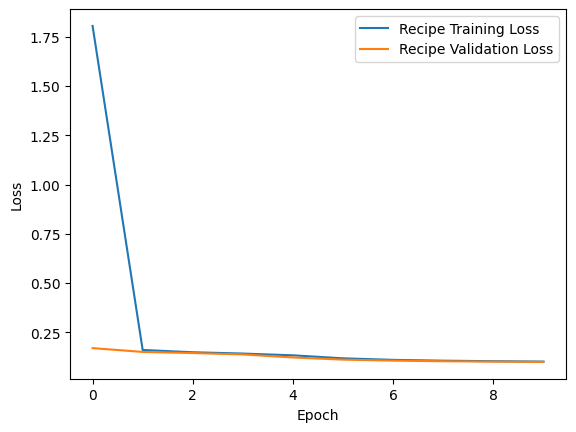

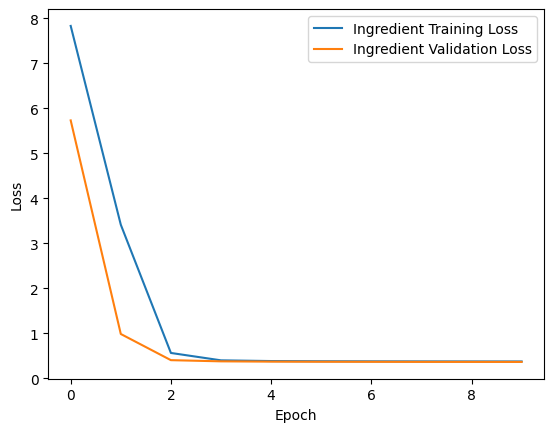

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


# Load preprocessed data
recipe_data_path = '/content/drive/MyDrive/generated_data/recipes.txt'  # Path to your dataset containing recipes
ingredient_data_path = '/content/drive/MyDrive/generated_data/ingredients.txt'  # Path to your dataset containing ingredients

# Read recipe and ingredient data
with open(recipe_data_path, 'r') as file:
    recipes = file.readlines()

with open(ingredient_data_path, 'r') as file:
    ingredients = file.readlines()

# Tokenize the data
tokenizer = Tokenizer(filters='', lower=False, oov_token='<OOV>')
tokenizer.fit_on_texts(recipes)

# Add the <end> token to the word_index manually
tokenizer.word_index['<end>'] = len(tokenizer.word_index) + 1

# Convert text to sequences
recipe_sequences = tokenizer.texts_to_sequences(recipes)
ingredient_sequences = tokenizer.texts_to_sequences(ingredients)

# Pad sequences to ensure uniform length
max_sequence_length = 1000  # Adjust as needed based on your dataset
recipe_padded = pad_sequences(recipe_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
ingredient_padded = pad_sequences(ingredient_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Split into input and target
X_recipe = recipe_padded[:, :-1]
y_recipe = recipe_padded[:, 1:]
X_ingredient = ingredient_padded[:, :-1]
y_ingredient = ingredient_padded[:, 1:]

# Define LSTM model architecture
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # Adjust as needed

recipe_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length - 1),
    LSTM(150, return_sequences=True),
    Dense(vocab_size, activation='softmax')
])

ingredient_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length - 1),
    LSTM(150, return_sequences=True),
    Dense(vocab_size, activation='softmax')
])

# Compile the model
recipe_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ingredient_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
recipe_history = recipe_model.fit(X_recipe, y_recipe, validation_split=0.2, epochs=10, batch_size=64)
ingredient_history = ingredient_model.fit(X_ingredient, y_ingredient, validation_split=0.2, epochs=10, batch_size=64)

# Evaluate the model on the test dataset
recipe_test_loss, recipe_test_accuracy = recipe_model.evaluate(X_recipe, y_recipe)
ingredient_test_loss, ingredient_test_accuracy = ingredient_model.evaluate(X_ingredient, y_ingredient)

print("Recipe Test Loss:", recipe_test_loss)
print("Recipe Test Accuracy:", recipe_test_accuracy)

print("Ingredient Test Loss:", ingredient_test_loss)
print("Ingredient Test Accuracy:", ingredient_test_accuracy)

# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(recipe_history.history['loss'], label='Recipe Training Loss')
plt.plot(recipe_history.history['val_loss'], label='Recipe Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(ingredient_history.history['loss'], label='Ingredient Training Loss')
plt.plot(ingredient_history.history['val_loss'], label='Ingredient Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [5]:
def generate_recipe(model, tokenizer, ingredients, max_length=1000):
    # Tokenize the given ingredients
    ingredient_seq = tokenizer.texts_to_sequences([ingredients])[0]

    # Initialize the input sequence with the start token
    input_seq = [1] + ingredient_seq  # Assuming 1 is the index of the start token
    input_seq = pad_sequences([input_seq], maxlen=max_length - 1, padding='post')  # Adjusted max_length

    # Generate the recipe step by step
    recipe = []
    while True:
        # Predict the next word
        prediction = model.predict(input_seq)
        predicted_word_index = np.argmax(prediction)

        # Convert the predicted word index to the actual word
        predicted_word = tokenizer.index_word.get(predicted_word_index, '<OOV>')

        # Stop generating if the end token is predicted or the maximum length is reached
        if predicted_word == '<end>' or len(recipe) >= max_length:
            break

        # Append the predicted word to the recipe
        recipe.append(predicted_word)

        # Update the input sequence for the next iteration
        input_seq[0][:-1] = input_seq[0][1:]
        input_seq[0][-1] = predicted_word_index

    # Join the generated words to form the recipe text
    generated_recipe = ' '.join(recipe)

    return generated_recipe

# Example usage:
recipe = generate_recipe(recipe_model, tokenizer, "chicken, onion, tomato")
print(recipe)


1/1 [==============================] - 0s 35ms/step
<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> 